<a href="https://colab.research.google.com/github/reply2vikas/Project-1/blob/master/Asgn_14_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm
import gc
import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [0]:
import numpy as np
import skimage
import time, math
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf
import tensorflow.contrib.eager as t

import matplotlib.pyplot as plt
% matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import imgaug.augmenters as iaa

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,RandomScale,Rotate,HorizontalFlip,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,RandomCrop,PadIfNeeded,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,GridDistortion,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, ChannelShuffle,RandomContrast
)

In [0]:
# instead of using graph we are doing imediate execution
tf.enable_eager_execution()


In [4]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.91 #@param {type:"number"}
LEARNING_RATE = 0.45 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}
cutout_proba = 0.4
shift_proba = 0.2
scale_proba = 0.2
rotate_proba = 0.2
rot90_proba = 0.2
grid_proba = 0.25

no_aug_proba = 0.6

print(cutout_proba + shift_proba + scale_proba + rotate_proba + rot90_proba + grid_proba)

max_augs_per_image = 2

mixed_precision = False
xla_enabled = False

1.45


In [0]:
def get_cutout_eraser(p=0.5, s_l=0.05, s_h=0.15, r_1=0.4, r_2=1 / 0.4, 
                      v_l=-1,v_h=1,
                      max_erasures_per_image=1, pixel_level=True):
    """

    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        shape = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img
        mx = np.random.randint(1, max_erasures_per_image + 1)
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            else:
                c = np.random.uniform(v_l, v_h)

#             input_img = tf.Variable(input_img)
#             input_img = input_img[top:top + h, left:left + w, :].assign(tf.constant(c, shape=(h, w, img_c)))
            input_img[top:top + h, left:left + w, :] = c
#         
        return input_img

    return eraser

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
    fan = np.prod(shape[:-1])
    bound = 1 / math.sqrt(fan)
    return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
    def __init__(self, c_out):
        super().__init__()
        self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
        self.bn = tf.keras.layers.BatchNormalization(momentum=0.95, epsilon=1e-5)

    def call(self, inputs):
        return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
    def __init__(self, c_out, pool, res = False):
        super().__init__()
        self.conv_bn = ConvBN(c_out)
        self.pool = pool
        self.res = res
        if self.res:
            self.res1 = ConvBN(c_out)
            self.res2 = ConvBN(c_out)

    def call(self, inputs):
        h = self.pool(self.conv_bn(inputs))
        if self.res:
            h = h + self.res2(self.res1(h))
        return h

In [0]:

class DavidNet(tf.keras.Model):
    def __init__(self, c=64, weight=0.125):
        super().__init__()
        pool = tf.keras.layers.MaxPooling2D()
        self.init_conv_bn = ConvBN(c)
        self.blk1 = ResBlk(c*2, pool, res = True)
        self.blk2 = ResBlk(c*4, pool)
        self.blk3 = ResBlk(c*8, pool, res = True)
        self.pool = tf.keras.layers.GlobalMaxPool2D()
        self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
        self.weight = weight

    def call(self, x, y):
        h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
        h = self.linear(h) * self.weight
        ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
        loss = tf.reduce_sum(ce)
        correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
        return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

In [11]:
print(gc.collect())

model = DavidNet(weight=0.125)
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]

# lr_schedule = lambda t: np.interp([t], [0.0001, (EPOCHS+1)//5, EPOCHS-3, EPOCHS-2,EPOCHS-1, EPOCHS], [0, LEARNING_RATE, 0.09,0.06,0.03,0.001])[0]



global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)

if mixed_precision:
    opt = tf.train.experimental.enable_mixed_precision_graph_rewrite(opt)

data_aug1 = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
# data_aug1 = lambda x,y: (x,y)
# data_aug2 = lambda x,y: (tf.image.random_hue(tf.image.random_brightness(x,max_delta=0.1),max_delta=0.1),y)
# data_aug2 = lambda x,y: (x,y)
# data_aug3 = lambda x, y: (tf.image.random_contrast(tf.image.random_saturation(x, 0.7, 1.3),0.7, 1.3), y)
# data_aug3 = lambda x,y: (x,y)
# data_aug = lambda x, y:data_aug1(*data_aug2(*data_aug3(x,y)))
data_aug = lambda x, y:data_aug1(x,y)

# rot90 = lambda x,y: (tf.image.rot90(x, np.random.choice([0,1,3],p=[1-rot90_proba,rot90_proba/2,rot90_proba/2])),y)

cutout_fn = get_cutout_eraser(p=1.0, pixel_level=True)

rotate_one = lambda x : tf.keras.preprocessing.image.random_rotation(x, rg=45, row_axis=0,col_axis=1,channel_axis=2)



ssr = ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30,p=1.0)
rotate_one = lambda x: ssr(image=x)['image']

# 
rt = Rotate(limit=30,p=1.0)
rotate_one = lambda x: rt(image=x)['image']

rs = RandomScale(scale_limit=0.1, p=1.0)
scale_one = lambda x: rs(image=x)['image']

rshift = ShiftScaleRotate(shift_limit=0.05, scale_limit=0.0, rotate_limit=0,p=1.0)
shift_one = lambda x: rshift(image=x)['image']

# gds = GridDistortion(num_steps=8, distort_limit=0.3,p=1.0)
# gds_one = lambda x: gds(image=x)['image']

rcr = RandomCrop(40,40,p=1.0)
rcrop_one = lambda x: rcr(image=x)['image']

pad = PadIfNeeded(40,40)
pad_one = lambda x: pad(image=x)['image']

# rot90_one = lambda x:np.rot90(x, k=np.random.choice([1,3]))

def constrained_augs(imgs,epoch):
    imgs = np.copy(imgs)
    fns = [cutout_fn,shift_one,scale_one,rotate_one]
    probas = [cutout_proba,shift_proba,scale_proba,rotate_proba]
    for i,im in enumerate(imgs):
        num_augs = np.random.choice(list(range(max_augs_per_image+1)),p=[no_aug_proba]+[(1-no_aug_proba)/max_augs_per_image]*max_augs_per_image)   
        choices = np.random.choice(list(range(4)),size=num_augs,replace=False,p=probas)   
        
        if 4 in choices:
            choices = [4]
        
#         print(choices)
        
        for j in choices:
            im = fns[j](im)
            if im.shape[0]<40:
                im = pad_one(im)
            if im.shape[0]>40:
                im = rcrop_one(im)
        imgs[i] = im
    
    return imgs




321


In [12]:
x_train.shape

(50000, 40, 40, 3)

In [13]:
gc.collect()

0

In [14]:
print(gc.collect())
t1 = time.time()
train_data = {}
for epoch in range(EPOCHS):
    
    if epoch%2==1:
        print("Epoch = ",epoch," Time = ",(time.time()-t1))
    xt = constrained_augs(x_train, epoch)
    train_set = tf.data.Dataset.from_tensor_slices((xt, y_train)).map(data_aug, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(len_train).batch(len_train).prefetch(len_train)
#     train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

    i = 0
    for x,y in train_set:
        assert x.numpy().shape[0]==len_train
        train_set = (x.numpy(),y.numpy())
        i = i+1
    assert i==1
    train_data[epoch] = train_set
t2 = time.time()
"%.1f" %(t2-t1)

79
Epoch =  1  Time =  11.442243337631226
Epoch =  3  Time =  36.04864311218262
Epoch =  5  Time =  60.510441064834595
Epoch =  7  Time =  84.6737596988678
Epoch =  9  Time =  109.07089376449585
Epoch =  11  Time =  133.81232905387878
Epoch =  13  Time =  157.95786356925964
Epoch =  15  Time =  182.24968576431274
Epoch =  17  Time =  206.98028254508972
Epoch =  19  Time =  231.29131436347961
Epoch =  21  Time =  255.59214448928833
Epoch =  23  Time =  280.07941484451294


'292.3'

In [15]:
x_train.shape

(50000, 40, 40, 3)

In [16]:
x_test.shape

(10000, 32, 32, 3)

In [17]:
x.numpy().shape[0]

50000

In [18]:
len_train

50000

0
epoch = 1 lr: 0.0900 | train loss: 1.5918 train acc: 0.423 val loss: 1.5237 val acc: 0.528 epoch time: 72.80 time: 72.80
epoch = 2 lr: 0.1800 | train loss: 0.9416 train acc: 0.666 val loss: 1.5221 val acc: 0.600 epoch time: 61.08 time: 133.88
epoch = 3 lr: 0.2700 | train loss: 0.7519 train acc: 0.737 val loss: 0.7868 val acc: 0.737 epoch time: 60.99 time: 194.86
epoch = 4 lr: 0.3600 | train loss: 0.6620 train acc: 0.770 val loss: 0.7269 val acc: 0.765 epoch time: 60.96 time: 255.82
epoch = 5 lr: 0.4500 | train loss: 0.5951 train acc: 0.796 val loss: 0.6455 val acc: 0.788 epoch time: 60.98 time: 316.80
epoch = 6 lr: 0.4263 | train loss: 0.4879 train acc: 0.831 val loss: 0.6612 val acc: 0.790 epoch time: 61.29 time: 378.09
epoch = 7 lr: 0.4026 | train loss: 0.4127 train acc: 0.857 val loss: 0.6023 val acc: 0.815 epoch time: 61.03 time: 439.12
epoch = 8 lr: 0.3789 | train loss: 0.3650 train acc: 0.872 val loss: 0.5425 val acc: 0.824 epoch time: 61.10 time: 500.22
epoch = 9 lr: 0.3553 | 

<Figure size 432x288 with 0 Axes>

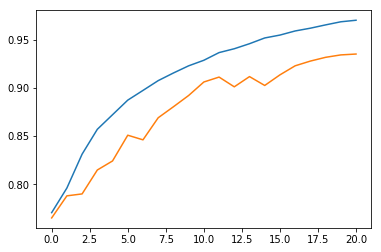

In [19]:
print(gc.collect())
t = time.time()
t_last = time.time()
train_accs = []
test_accs = []
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(1)

for epoch in range(EPOCHS):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()

    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)
    print("epoch = %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
   
  
    
plt.figure()
plt.plot(train_accs[3:])
plt.plot(test_accs[3:])
plt.show()

epoch = 1 lr: 0.0900 | train loss: 0.0881 train acc: 0.972 val loss: 0.2068 val acc: 0.935 epoch time: 61.45 time: 1538.64
epoch = 2 lr: 0.1800 | train loss: 0.0865 train acc: 0.972 val loss: 0.2073 val acc: 0.935 epoch time: 61.03 time: 1599.67
epoch = 3 lr: 0.2700 | train loss: 0.0848 train acc: 0.973 val loss: 0.2069 val acc: 0.935 epoch time: 61.21 time: 1660.88
epoch = 4 lr: 0.3600 | train loss: 0.0828 train acc: 0.974 val loss: 0.2071 val acc: 0.934 epoch time: 61.08 time: 1721.96
epoch = 5 lr: 0.4500 | train loss: 0.0779 train acc: 0.975 val loss: 0.2067 val acc: 0.935 epoch time: 61.22 time: 1783.19


<Figure size 432x288 with 0 Axes>

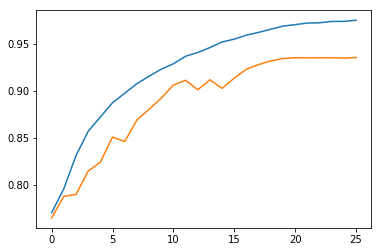

In [20]:
for epoch in range(5):
    train_loss = test_loss = train_acc = test_acc = 0.0
    train_set = train_data[epoch]
    train_set = tf.data.Dataset.from_tensor_slices(train_set).batch(BATCH_SIZE).prefetch(1)
    tf.keras.backend.set_learning_phase(1)
    for (x, y) in train_set:
        with tf.GradientTape() as tape:
            loss, correct = model(x, y)

        var = model.trainable_variables
        grads = tape.gradient(loss, var)
        for g, v in zip(grads, var):
            g += v * (WEIGHT_DECAY/(epoch+1)) * BATCH_SIZE
        opt.apply_gradients(zip(grads, var), global_step=global_step)

        train_loss += loss.numpy()
        train_acc += correct.numpy()

    tf.keras.backend.set_learning_phase(0)
    for (x, y) in test_set:
        loss, correct = model(x, y)
        test_loss += loss.numpy()
        test_acc += correct.numpy()

    t2 = time.time()
    epoch_time = t2 - t_last
    t_last = t2
    train_accs.append(train_acc / len_train)
    test_accs.append(test_acc / len_test)
    print("epoch = %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))
    
    
plt.figure()
plt.plot(train_accs[3:])
plt.plot(test_accs[3:])
plt.show()

In [28]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
#%cd /gdrive/Colab Notebooks/

In [30]:
!ls

sample_data


In [0]:
# tf.train.Saver.save(model,"cifar10_model")

In [32]:
print("epoch = %s"%(epoch+1),'lr: %.4f' % (lr_schedule(epoch+1)), '| train loss: %.4f' %(train_loss / len_train), 'train acc: %.3f' % (train_acc / len_train), 'val loss: %.4f' % (test_loss / len_test), 'val acc: %.3f' %(test_acc / len_test),"epoch time: %.2f"%(epoch_time), 'time: %.2f'%(t2 - t))

epoch = 5 lr: 0.4500 | train loss: 0.0779 train acc: 0.975 val loss: 0.2067 val acc: 0.935 epoch time: 61.22 time: 1783.19


In [0]:
#observations

In [0]:
#1) adding bias doesn't help
#2) using cutout_proba,shift_proba,scale_proba,rotate_proba 0.4,0.2,0.2,0.2 gave 93.2 in 24 epochs
#3) using cutout_proba,shift_proba,scale_proba,rotate_proba 0.4,0.1,0.1,0.4 gave 93.5 in 24 epochs
#4) using cutout_proba,shift_proba,scale_proba,rotate_proba 0.5,0.05,0.05,0.4 gave 93.2 in 24 epochs and cutout_eraser 0.4
#5) using cutout_proba,shift_proba,scale_proba,rotate_proba 0.4,0.1,0.1,0.4 gave 93.5 in 24 epochs and momentum in bn as 0.95
#6) using cutout_proba,shift_proba,scale_proba,rotate_proba 0.4,0.2,0.2,0.2 gave 93.9 in 34 epochs
#7) using cutout_proba,shift_proba,scale_proba,rotate_proba,rot90_proba 0.4,0.1,0.2,0.2,0.1 gave 93.7 in 35 epochs with momentum 0.95